In [1]:
!nvidia-smi

Tue Jul 28 14:19:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
from IPython.display import Image, clear_output 

print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.5.1+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)


In [15]:
!pip install ipython-autotime
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=4c1ee7def74391f3816c3f054b778445057a4705f042bb2f6b5491e51db98dc4
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


# Dataset preparation

In [3]:
import os,glob,gc

gc.enable()
from zipfile import ZipFile

homepath = '/content/drive/My Drive/EVA4/P2_S2_MobilenetV2'
dataset  = os.path.join(homepath,'dataset.zip')

os.chdir(homepath)

In [4]:
with ZipFile(dataset) as z:
    print('Total Number of images in a dataset.zip folder : %i'%int(len(z.infolist())-5))
    if not os.path.exists('dataset'):
        #z.extractall()
        !unzip dataset.zip
        print('Extracted!')
    else:
        print('dataset folder exists')
        print('Total number of images in dataset Folder \t: %i'%int(len(glob.glob('/content/drive/My Drive/EVA4/P2_S2_MobilenetV2/dataset/*/*'))))


Total Number of images in a dataset.zip folder : 21350
dataset folder exists
Total number of images in dataset Folder 	: 21350


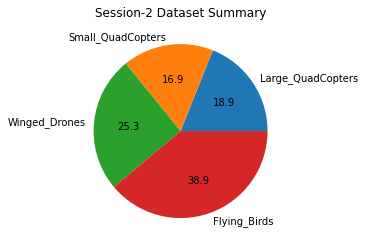

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

dspth = dataset.split('.zip')[0]
plt.pie( 
        list(map(lambda f : len(os.listdir(os.path.join(dspth,f))), os.listdir(dspth))),
        labels = os.listdir(dspth) ,
        autopct='%0.1f')

plt.title('Session-2 Dataset Summary')
plt.show()
    

# Load dataset

In [11]:
import torch,torchvision
transform = torchvision.transforms.Compose([#torchvision.transforms.Resize([224,224]),
                                #torchvision.transforms.CenterCrop(224),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(mean=[0.5332, 0.5855, 0.6169],std=[0.1747, 0.1697, 0.1862])])

ds = torchvision.datasets.ImageFolder(dspth, transform=transform)
dl = torch.utils.data.DataLoader(ds, batch_size=256,shuffle=True)

# Calculate Mean and Std

In [12]:
def calcMeanStd(dl):
    mean = 0.
    std = 0.
    nb_samples = 0.
    from IPython.core.debugger import set_trace

    for data,lbl in dl:
        #set_trace()
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples

    print('Mean is \t: {}\nstd is \t: {}\nnb_samples \t:{}'.format(mean,std,nb_samples))

#calcMeanStd(dl)

In [13]:
SEED = 1
cuda = torch.cuda.is_available()
print(cuda)
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=8, pin_memory=True) if cuda else dict(shuffle=True, batch_size=128)

trainds, testds = torch.utils.data.random_split(dataset=ds, lengths=[len(ds)-int(0.3*len(ds)), int(0.3*len(ds)) ])
print('Length of Train DS is : {}\nLength of Test DS is  : {}'.format(len(trainds), len(testds)))
    
traindl = torch.utils.data.DataLoader(trainds,  **dataloader_args)
testdl  = torch.utils.data.DataLoader(testds, **dataloader_args)

print('Dataset contains {} - classes : \n\t{}'.format(len(ds.classes),dl.dataset.class_to_idx))
#calcMeanStd(traindl)
#calcMeanStd(testdl)
del ds,dl

True
Length of Train DS is : 14945
Length of Test DS is  : 6405
Dataset contains 4 - classes : 
	{'Flying_Birds': 0, 'Large_QuadCopters': 1, 'Small_QuadCopters': 2, 'Winged_Drones': 3}


In [14]:
'''
dataiter = iter(traindl)
img,lbl = dataiter.next()
print(img.shape,lbl)
'''

torch.Size([128, 3, 224, 224]) tensor([3, 0, 0, 2, 3, 0, 1, 0, 0, 0, 2, 0, 3, 3, 3, 0, 1, 0, 2, 2, 0, 3, 3, 0,
        3, 2, 0, 3, 1, 3, 0, 0, 3, 2, 2, 3, 0, 3, 3, 0, 0, 0, 0, 2, 3, 0, 3, 0,
        1, 3, 0, 1, 0, 0, 0, 0, 1, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 3, 2, 1, 0, 2,
        3, 2, 2, 0, 2, 3, 2, 3, 3, 1, 2, 0, 3, 2, 0, 3, 0, 2, 0, 0, 0, 0, 2, 1,
        0, 0, 2, 3, 3, 0, 3, 3, 3, 2, 3, 3, 2, 3, 0, 0, 0, 2, 1, 0, 0, 3, 0, 0,
        3, 2, 0, 3, 1, 2, 3, 0])


In [16]:
def show(imgs,lbls=None, figsize=(100,100), *args, **kwargs):
    grid_tensor = torchvision.utils.make_grid(imgs[:8], *args, **kwargs)
    grid_image  = grid_tensor.permute(1,2,0)
    plt.figtext(100,100,'Images')
    plt.figure(figsize=figsize)
    plt.imshow(grid_image)
    plt.xticks([])
    plt.yticks([])
    #plt.xlabel(xlabel=list(lbls))
    plt.show()
    
    if lbls is not None:
        print(' '.join('%15s' % [lbls[j]] for j in range(10)))
    plt.close()

time: 12.8 ms


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

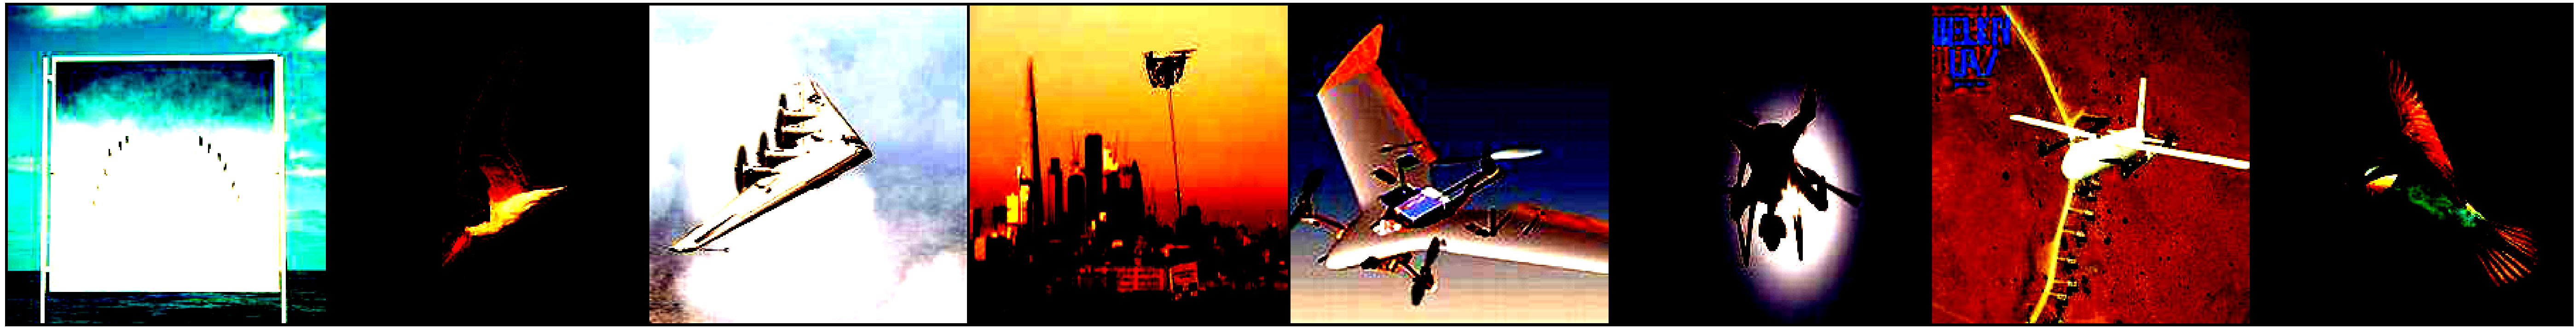

            [0]             [0]             [3]             [1]             [3]             [2]             [3]             [0]             [3]             [2]
time: 1min 23s


In [17]:
import numpy as np
image, label = next(iter(traindl))
show(image,np.array(list(label)))

# Model 

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=False)
#model.to(device)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip


time: 880 ms


In [19]:
 model.classifier[1]

Linear(in_features=1280, out_features=1000, bias=True)

time: 3.15 ms


In [20]:
for param in model.parameters():
    param.requires_grad = False    

n_inputs = model.classifier[1].in_features
print(n_inputs)

model.classifier = torch.nn.Sequential(torch.nn.Linear(n_inputs, 512),
                            #torch.nn.ReLU6(inplace=True),
                            # torch.nn.Dropout(0.2),
                            torch.nn.Linear(512, 4),
                            torch.nn.LogSoftmax(dim=1))

1280
time: 12.7 ms


In [21]:
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

time: 31.7 ms


In [22]:
import torchsummary

torchsummary.summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

# Train and Validate

In [23]:
def train_model(model, batch_size, patience, n_epochs):
    train_losses,valid_losses, avg_train_losses,avg_valid_losses   = [],[],[],[]
    for epoch in range(1, n_epochs + 1):
        '''
        for param_group in optimizer.param_groups:
          lr = param_group["lr"]
          print(f'\n **** learning rate: {lr}')'''
        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for inputs, target in traindl:
            inputs, target = inputs.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        ######################    
        # Test the model #
        ######################
        model.eval() # prep model for evaluation
        correct = 0
        total = 0
        accuracy = 0
        for inputs, target in testdl:
            inputs, target = inputs.to(device), target.to(device)
            output = model(inputs)
            _, predicted = torch.max(output.data, 1)

            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())
            
            total += target.size(0)
            correct += (predicted == target).sum().item()
        
        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        valid_accuracy = (100.0 * correct) / total

        epoch_len = len(str(n_epochs))

        print_msg = (f'\n[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'\tvalid_loss: {valid_loss:.5f}' +
                     f'\tvalid_accuracy: {valid_accuracy:.2f}')
        
        print(print_msg)

       
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        valid_accuracy = round(valid_accuracy, 2)
        ''' suman
        scheduler.step(valid_accuracy)

        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        model_path = 'checkpoint.pt' # f'jantahackathon_v13_{valid_accuracy}.pth'
        
        early_stopping(valid_accuracy, model, model_path)

        if early_stopping.early_stop:
            print("Early stopping")
            if early_stopping.best_score is not None:
              print(f'Best score: {early_stopping.best_score}')
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(model_path))
    '''

    return  model, avg_train_losses, avg_valid_losses

time: 38.4 ms


# Mini-Batch SGD

In [ ]:
# Loss
criterion = torch.nn.CrossEntropyLoss()
lr = 0.1
optimizer = torch.optim.SGD(model.parameters(),lr = lr)

model, train_loss, valid_loss = train_model(model, batch_size=512, patience=None, n_epochs=5)


[1/5] train_loss: 1.28693 	valid_loss: 1.29369	valid_accuracy: 40.61

[2/5] train_loss: 1.28062 	valid_loss: 1.31570	valid_accuracy: 41.90

[3/5] train_loss: 1.27667 	valid_loss: 1.30427	valid_accuracy: 40.91

[4/5] train_loss: 1.27751 	valid_loss: 1.27645	valid_accuracy: 41.48

[5/5] train_loss: 1.26830 	valid_loss: 1.27278	valid_accuracy: 43.04


# SGD with momentum with nesterov

In [ ]:
# Loss
criterion = torch.nn.CrossEntropyLoss()
lr = 0.1
optimizer = torch.optim.SGD(model.parameters(),lr = lr,momentum=0.9,nesterov=True)

model, train_loss, valid_loss = train_model(model, batch_size=512, patience=None, n_epochs=5)


[1/5] train_loss: 1.28712 	valid_loss: 1.27891	valid_accuracy: 42.12

[2/5] train_loss: 1.27616 	valid_loss: 1.26193	valid_accuracy: 43.28

[3/5] train_loss: 1.26938 	valid_loss: 1.29170	valid_accuracy: 41.58

[4/5] train_loss: 1.26104 	valid_loss: 1.29891	valid_accuracy: 41.70

[5/5] train_loss: 1.25851 	valid_loss: 1.27197	valid_accuracy: 42.36


# LR Finder 

  pip install torch-lr-finder -v --global-option="amp"


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


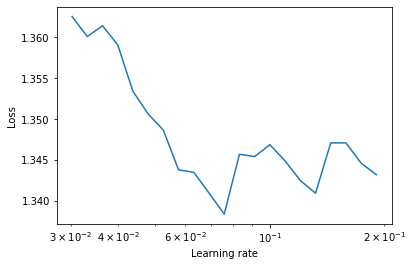

Min loss value is : 1.3383564676477866 
Min LR value is   : 0.0120226443
time: 3min 48s


In [24]:
from torch_lrfinder import LRFinder

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.9,nesterov=True)
#optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(traindl, end_lr=100, num_iter=100, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

print('Min loss value is : {} \nMin LR value is   : {}'.format(min(lr_finder.history['loss']),format(min(lr_finder.history['lr']),'.10f')))

In [25]:
print('Min loss observed at index : {}'.format(lr_finder.history['loss'].index(min(lr_finder.history['loss']))))
print(lr_finder.history['lr'][lr_finder.history['loss'].index(min(lr_finder.history['loss']))])

Min loss observed at index : 20
0.07585775750291837
time: 1.64 ms


In [26]:
# Loss
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(),lr = 6e-2,momentum=0.9,nesterov=True)

model, train_loss, valid_loss = train_model(model, batch_size=512, patience=None, n_epochs=5)


[1/5] train_loss: 1.30088 	valid_loss: 1.27079	valid_accuracy: 42.84

[2/5] train_loss: 1.27489 	valid_loss: 1.25826	valid_accuracy: 44.22

[3/5] train_loss: 1.26596 	valid_loss: 1.25864	valid_accuracy: 44.12

[4/5] train_loss: 1.26577 	valid_loss: 1.25398	valid_accuracy: 44.32

[5/5] train_loss: 1.25269 	valid_loss: 1.27716	valid_accuracy: 42.22
time: 14min 37s


In [27]:

model, train_loss, valid_loss = train_model(model, batch_size=512, patience=None, n_epochs=10)


[ 1/10] train_loss: 1.25678 	valid_loss: 1.27577	valid_accuracy: 40.61

[ 2/10] train_loss: 1.24223 	valid_loss: 1.24779	valid_accuracy: 44.47

[ 3/10] train_loss: 1.24188 	valid_loss: 1.22574	valid_accuracy: 45.90

[ 4/10] train_loss: 1.24107 	valid_loss: 1.21537	valid_accuracy: 46.48

[ 5/10] train_loss: 1.23645 	valid_loss: 1.25838	valid_accuracy: 41.73

[ 6/10] train_loss: 1.23812 	valid_loss: 1.23417	valid_accuracy: 45.65

[ 7/10] train_loss: 1.23592 	valid_loss: 1.23758	valid_accuracy: 45.73

[ 8/10] train_loss: 1.23397 	valid_loss: 1.27581	valid_accuracy: 44.37

[ 9/10] train_loss: 1.23636 	valid_loss: 1.24531	valid_accuracy: 45.03

[10/10] train_loss: 1.23443 	valid_loss: 1.21139	valid_accuracy: 46.42
time: 10min 37s


In [29]:

model, train_loss, valid_loss = train_model(model, batch_size=512, patience=None, n_epochs=10)


[ 1/10] train_loss: 1.21945 	valid_loss: 1.20997	valid_accuracy: 46.49

[ 2/10] train_loss: 1.21506 	valid_loss: 1.22605	valid_accuracy: 44.11

[ 3/10] train_loss: 1.22122 	valid_loss: 1.25042	valid_accuracy: 43.09

[ 4/10] train_loss: 1.22223 	valid_loss: 1.21256	valid_accuracy: 46.93

[ 5/10] train_loss: 1.22197 	valid_loss: 1.21556	valid_accuracy: 45.90

[ 6/10] train_loss: 1.21999 	valid_loss: 1.21485	valid_accuracy: 46.15

[ 7/10] train_loss: 1.21388 	valid_loss: 1.21377	valid_accuracy: 47.28

[ 8/10] train_loss: 1.21363 	valid_loss: 1.22692	valid_accuracy: 46.15

[ 9/10] train_loss: 1.21426 	valid_loss: 1.22932	valid_accuracy: 46.84

[10/10] train_loss: 1.21746 	valid_loss: 1.19633	valid_accuracy: 47.06
time: 10min 38s


In [30]:
model, train_loss, valid_loss = train_model(model, batch_size=512, patience=None, n_epochs=10)


[ 1/10] train_loss: 1.21843 	valid_loss: 1.23897	valid_accuracy: 45.11

[ 2/10] train_loss: 1.20928 	valid_loss: 1.20291	valid_accuracy: 47.81

[ 3/10] train_loss: 1.21328 	valid_loss: 1.21340	valid_accuracy: 47.06

[ 4/10] train_loss: 1.21193 	valid_loss: 1.22479	valid_accuracy: 46.62

[ 5/10] train_loss: 1.21676 	valid_loss: 1.21503	valid_accuracy: 46.28

[ 6/10] train_loss: 1.21642 	valid_loss: 1.21405	valid_accuracy: 45.89

[ 7/10] train_loss: 1.21106 	valid_loss: 1.20827	valid_accuracy: 46.65

[ 8/10] train_loss: 1.20893 	valid_loss: 1.21786	valid_accuracy: 46.78

[ 9/10] train_loss: 1.21343 	valid_loss: 1.24519	valid_accuracy: 45.65

[10/10] train_loss: 1.20717 	valid_loss: 1.20531	valid_accuracy: 46.78
time: 10min 39s


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


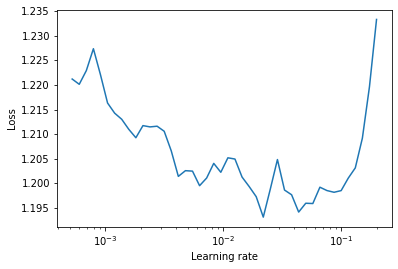

Min loss value is : 1.193132009242759 
Min LR value is   : 0.0001318257
time: 29.4 s


In [32]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001,momentum=0.9,nesterov=True)
#optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(traindl, end_lr=100, num_iter=100, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

print('Min loss value is : {} \nMin LR value is   : {}'.format(min(lr_finder.history['loss']),format(min(lr_finder.history['lr']),'.10f')))

In [33]:
print('Min loss observed at index : {}'.format(lr_finder.history['loss'].index(min(lr_finder.history['loss']))))
print(lr_finder.history['lr'][lr_finder.history['loss'].index(min(lr_finder.history['loss']))])

Min loss observed at index : 37
0.02187761623949553
time: 2.84 ms


In [34]:
# Loss
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(),lr = 0.00218,momentum=0.9,nesterov=True)

model, train_loss, valid_loss = train_model(model, batch_size=512, patience=None, n_epochs=10)


[ 1/10] train_loss: 1.19045 	valid_loss: 1.18539	valid_accuracy: 47.62

[ 2/10] train_loss: 1.19188 	valid_loss: 1.19166	valid_accuracy: 46.96

[ 3/10] train_loss: 1.18717 	valid_loss: 1.19241	valid_accuracy: 47.48

[ 4/10] train_loss: 1.18780 	valid_loss: 1.19938	valid_accuracy: 46.32

[ 5/10] train_loss: 1.18964 	valid_loss: 1.20593	valid_accuracy: 47.46

[ 6/10] train_loss: 1.19087 	valid_loss: 1.20251	valid_accuracy: 46.78

[ 7/10] train_loss: 1.18635 	valid_loss: 1.19919	valid_accuracy: 46.96

[ 8/10] train_loss: 1.18921 	valid_loss: 1.19457	valid_accuracy: 47.21

[ 9/10] train_loss: 1.18798 	valid_loss: 1.20067	valid_accuracy: 47.76

[10/10] train_loss: 1.18808 	valid_loss: 1.19767	valid_accuracy: 47.35
time: 10min 57s


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


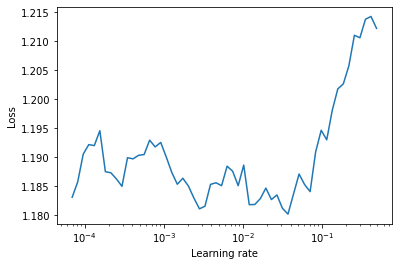

Min loss value is : 1.1773131853342056 
Min LR value is   : 0.0000138038
time: 33.4 s


In [39]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001,momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(traindl, end_lr=100, num_iter=100, step_mode="exp")
lr_finder.plot(log_lr=True) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

print('Min loss value is : {} \nMin LR value is   : {}'.format(min(lr_finder.history['loss']),format(min(lr_finder.history['lr']),'.10f')))

print('Min loss observed at index : {}'.format(lr_finder.history['loss'].index(min(lr_finder.history['loss']))))
print(lr_finder.history['lr'][lr_finder.history['loss'].index(min(lr_finder.history['loss']))])

In [ ]:
# Loss
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(),lr = 1e-2,momentum=0.9,nesterov=True)

model, train_loss, valid_loss = train_model(model, batch_size=512, patience=None, n_epochs=10)


[ 1/10] train_loss: 1.19029 	valid_loss: 1.19881	valid_accuracy: 47.37

[ 2/10] train_loss: 1.19267 	valid_loss: 1.21513	valid_accuracy: 47.17

[ 3/10] train_loss: 1.19147 	valid_loss: 1.20494	valid_accuracy: 47.38

[ 4/10] train_loss: 1.19235 	valid_loss: 1.19710	valid_accuracy: 46.85

[ 5/10] train_loss: 1.18670 	valid_loss: 1.23472	valid_accuracy: 44.26


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8756b858d0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process



[ 6/10] train_loss: 1.18808 	valid_loss: 1.21686	valid_accuracy: 46.14


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8756b858d0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8756b858d0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/l


[ 7/10] train_loss: 1.19003 	valid_loss: 1.20054	valid_accuracy: 48.09


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8756b858d0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8756b858d0>>
Traceback (most recent call last):
AssertionError: can only join a child process
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/l


[ 8/10] train_loss: 1.19288 	valid_loss: 1.21035	valid_accuracy: 46.42


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8756b858d0>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8756b858d0>>
Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8756b858d0>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/data

# Save Model

In [ ]:
savedModel = 'mobilenetv2_47_per.pt'
torch.save(model, savedModel)
model=torch.load(savedModel)
#model.eval()

In [36]:
!ls

dataset			   mobilenetv2_47_per.pt	  torch_lrfinder.py
dataset.zip		   mobilenetV2_4ClassGroup.ipynb
E4P2_S2_MobilenetV2.ipynb  __pycache__
time: 2.3 s


# End

In [ ]:
from torch.optim.lr_scheduler import StepLR

learning_rate = 0.01
momentum = 0.9
step_size = 2
gamma = 0.96

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=momentum,
    nesterov=True) 

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=1,
    verbose=False, 
    threshold=0.0001,
    threshold_mode='abs',
    cooldown=0, 
    min_lr=1e-8,
    eps=1e-08
)

In [ ]:
class EarlyStoppingOnAcc:
    def __init__(self, patience=7, mode="max", delta=0.0001, model_path='checkpoint.pt'):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.model_path = model_path
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):
        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(
                "EarlyStopping counter: {} out of {}".format(
                    self.counter, self.patience
                )
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print(
                "Validation score improved ({} --> {}). Saving model!".format(
                    self.val_score, epoch_score
                )
            )
            torch.save(model.state_dict(), model_path)
            traced_model = torch.jit.trace(model.float(), torch.randn(1,3,224,224).to(device))
            torch.jit.save(traced_model, 'mobilenet_v2_best.pt')
            # traced_model.save('modelnet_v2_44_77.pt')
            torch.save(model, 'model.pt')
        self.val_score = epoch_score

In [ ]:
def train_model(model, batch_size, patience, n_epochs):
   
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    # early_stopping = EarlyStopping(patience=patience, verbose=True)
    early_stopping = EarlyStoppingOnAcc(patience=patience)
    
    for epoch in range(1, n_epochs + 1):
        for param_group in optimizer.param_groups:
          lr = param_group["lr"]
          print(f'\n **** learning rate: {lr}')
        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for inputs, target in traindl:
            inputs, target = inputs.to(device), target.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(inputs)
            # calculate the loss
            loss = criterion(output, target)
            
            # loss = Variable(loss, requires_grad = True)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
        
        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        correct = 0
        total = 0
        accuracy = 0
        for inputs, target in testdl:
            inputs, target = inputs.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(inputs)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        
        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        valid_accuracy = 100 * correct / total

        epoch_len = len(str(n_epochs))

        print_msg = (f'\n[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'\tvalid_loss: {valid_loss:.5f}' +
                     f'\tvalid_accuracy: {valid_accuracy:.2f}')
        
        print(print_msg)

        # Tensorboard logging
        '''tb.add_scalar('Loss - Train loss',
                            train_loss / len(train_loader),
                            epoch * len(train_loader))
            
        tb.add_scalar('Loss - Val',
                        valid_loss/len(val_loader),
                        epoch * len(val_loader))
        
        tb.add_scalar('Accuracy - Val',
                            valid_accuracy/len(val_loader),
                            epoch * len(val_loader))'''
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        valid_accuracy = round(valid_accuracy, 2)
        scheduler.step(valid_accuracy)
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        model_path = 'checkpoint.pt' # f'jantahackathon_v13_{valid_accuracy}.pth'
        early_stopping(valid_accuracy, model, model_path)

        if early_stopping.early_stop:
            print("Early stopping")
            if early_stopping.best_score is not None:
              print(f'Best score: {early_stopping.best_score}')
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(model_path))

    return  model, avg_train_losses, avg_valid_losses

In [ ]:
batch_size = 512
n_epochs = 1

# train_loader, test_loader, valid_loader = create_datasets(batch_size)

# early stopping patience; how long to wait after last time validation loss improved.
patience = 10

model, train_loss, valid_loss = train_model(model, batch_size, patience, n_epochs)

In [ ]:
batch_size = 512
n_epochs = 10

# train_loader, test_loader, valid_loader = create_datasets(batch_size)

# early stopping patience; how long to wait after last time validation loss improved.
patience = 10

model, train_loss, valid_loss = train_model(model, batch_size, patience, n_epochs)

In [ ]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, max(train_loss) + 0.2) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')